## <span style="color:#40e0d0">**Analyze and Visualize Simulation Data**</span>

[0.0008696698611017179, 0.2301637236681236, 0.4974133699648475, -0.9308125178847049, -1.617438247287649, -4.340226755911444, 8.974842998835195, 8.334697288745241, 29.802879525541208]
  0.402020 seconds (632.41 k allocations: 62.914 MiB, 2.05% gc time, 93.96% compilation time: 3% of which was recompilation)
[2.101849740856425e-6, -1.6181004351325425]
  0.003312 seconds (1.63 k allocations: 3.263 MiB)
  0.179371 seconds (365.10 k allocations: 33.686 MiB, 2.89% gc time, 98.20% compilation time)


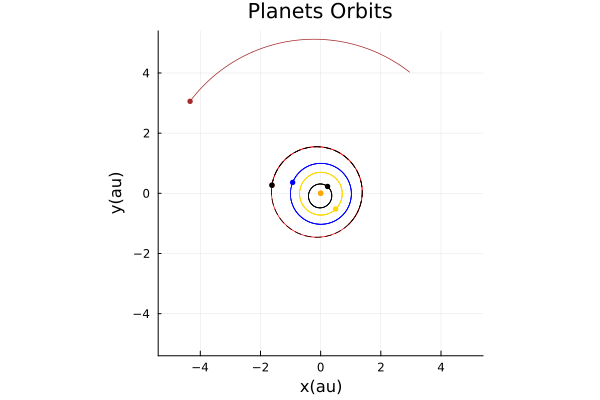

In [1]:
using LinearAlgebra
using Statistics
using Plots
using FFMPEG
using JSON
using HDF5

#=
length:km, mass:kg, time:s, angle:rad(deg in json)
(interval must be a multiple of dt, tEnd must be a multiple of interval)
=#

colors = [:orange, :black, :gold, :blue, :red, :brown, :bisque4, :gray, :blue] #惑星の色
AU = 1.495978e8 #AU

function plotAllWithChunks(plot::Plots.Plot, N::Int, file::HDF5.File, tEnd::Float64, dt::Float64, chunk_size::Int64, linestyle)
    Nt = Int(ceil(tEnd/dt))
    for c in 1:Int(Nt/chunk_size)
        chunk = read(file, "/data/$c")
        for i in 2:N
            X = chunk[i,1,:] ./ AU
            Y = chunk[i,2,:] ./ AU
            plot!(plot, X, Y, color=colors[i], lw=0.75, ls=linestyle)
        end
    end
    Xe = read(file, "/data/$(Int(Nt/chunk_size))")[:,1,end] ./ AU
    Ye = read(file, "/data/$(Int(Nt/chunk_size))")[:,2,end] ./ AU
    println(Xe)
    scatter!(plot, Xe, Ye, color=colors[1:N], markersize=3, marker_stroke=nothing, markerstrokewidth=0)
    return plot
end

function plotAllWithChunks(N::Int, file::HDF5.File, tEnd::Float64, dt::Float64, range::Float64, title, chunk_size::Int, linestyle)
    plot = scatter([], [], xlims=(-range,range), ylims=(-range,range), title=title, xlabel="x(au)", ylabel="y(au)", aspect_ratio=:equal, legend=false)
    return plotAllWithChunks(plot, N, file, tEnd, dt, chunk_size, linestyle)
end

function distanceOnSameTime(file1, file2, tEnd, dt, title, chunk_size, i1, i2)
    Nt = Int(ceil(tEnd/dt))
    d = zeros(Nt) #risk of crash in case of the huge Nt
    for c in 1:Int(Nt/chunk_size)
        chunk1 = read(file1, "/data/$c")[i1,:,:]
        chunk2 = read(file2, "/data/$c")[i2,:,:]
        d[(c-1)*chunk_size+1:c*chunk_size] = sum((chunk1 .- chunk2).^2, dims=1).^0.5
    end

    p = plot(1:Nt, d, title=title, legend=false, xlabel="time(s)", ylabel="distance(km)")
    return p
end


function main()
    f1 = h5open("../Gravitational_Simulation/results/dt1hr_tEnd1080d/all.h5", "r")
    f2 = h5open("../Gravitational_Simulation/results/dt1hr_tEnd1080d/mars.h5", "r")
    tEnd = read(f1, "/params/tend")
    dt = read(f1, "/params/dt")
    chunk_size = read(f1, "/params/chunksize")
    if tEnd == read(f2, "/params/tend") && dt == read(f2, "/params/dt") && chunk_size == read(f2, "/params/chunksize")
        N1 = read(f1, "/params/n")
        N2 = read(f2, "/params/n")

        @time _p = plotAllWithChunks(N1, f1, tEnd, dt, 5.4, "Planets Orbits", chunk_size, :solid)
        @time p1 = plotAllWithChunks(_p, N2, f2, tEnd, dt, chunk_size, :dash)

        @time p2 = distanceOnSameTime(f1, f2, tEnd, dt, "Distance between two Jupiter motion", chunk_size, 5, 2)

        display(p1)
        display(p2)
    else
        println("Endtime, delta time or chunk size does not match.")
    end
    close(f1)
    close(f2)
end
gr()
main()
